import os
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'
# Option 6 — Segmentation Channel Input (Direct Classification)

**Key Idea**: Pass rule-based lung segmentation as an additional input channel to the network.

- Input: 2 channels (grayscale image + lung segmentation mask)
- The network learns to leverage spatial lung region information
- Modified MobileNetV2 with 2-channel input instead of 3 RGB channels

In [11]:
# Imports & config
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import roc_auc_score
import cv2
import random

# Basic hyperparams (tune as needed)
class CFG:
    img_size = 224
    batch_size = 32
    epochs = 8
    lr = 1e-4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    subset_size = None  # set int for faster testing
    in_channels = 2  # grayscale image + segmentation mask
cfg = CFG()
print(f'Device: {cfg.device}')
print(f'Input channels: {cfg.in_channels} (image + segmentation mask)')

# Specify your custom folder path here
CUSTOM_DATA_PATH = "datasets"  # Change this to your desired folder

# Create the folder if it doesn't exist
os.makedirs(CUSTOM_DATA_PATH, exist_ok=True)

Device: cuda
Input channels: 2 (image + segmentation mask)


In [12]:
# Load labels and image paths (same dataset used previously)
try:
    import kagglehub
    path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
    BASE_PATH = Path(path)
except Exception:
    BASE_PATH = Path('.')  # change to dataset root if needed

print(f'Using dataset base: {BASE_PATH}')
df = pd.read_csv(BASE_PATH / 'Data_Entry_2017.csv')
images_dir = BASE_PATH / 'images-224' / 'images-224'
df['Image Path'] = [str(images_dir / p) for p in df['Image Index'].values]

DISEASE_CATEGORIES = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]
for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

print(f'Loaded {len(df):,} images')
print(f'Diseases: {len(DISEASE_CATEGORIES)}')

Using dataset base: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
Loaded 112,120 images
Diseases: 14


In [13]:
# Patient-level split (same logic as originals)
from sklearn.model_selection import train_test_split
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=42)
train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

if cfg.subset_size:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    test_df = test_df.head(cfg.subset_size // 8)

print('Train/Val/Test sizes:', len(train_df), len(val_df), len(test_df))

Train/Val/Test sizes: 103847 5974 2299


In [14]:
# =============================================================================
# Load Pre-Computed Lung Segmentation Masks
# =============================================================================
# Masks pre-computed by precompute_lung_masks.ipynb

if IN_KAGGLE:
    PIXEL_MASK_DIR = "/kaggle/working/lung_masks/pixel_masks"
else:
    PIXEL_MASK_DIR = "./lung_masks/pixel_masks"

def load_precomputed_mask(img_name, mask_dir=PIXEL_MASK_DIR, img_size=224):
    """Load pre-computed pixel-level lung mask from disk."""
    mask_name = img_name.replace(".png", "")
    mask = np.load(os.path.join(mask_dir, f"{mask_name}.npy"))
    if mask.dtype == np.uint8:
        mask = mask.astype(np.float32) / 255.0
    if mask.shape[0] != img_size or mask.shape[1] != img_size:
        mask = cv2.resize(mask, (img_size, img_size))
    return mask

print(f"Masks loaded from: {PIXEL_MASK_DIR}")
print(f"✅ Mask loader ready. Mask dir: {PIXEL_MASK_DIR}")


Segmentation functions defined


In [15]:
# =============================================================================
# Dataset with Segmentation as Additional Input Channel
# =============================================================================

class SegmentationChannelDataset(Dataset):
    """
    Dataset that provides 2-channel input:
    - Channel 0: Grayscale chest X-ray image
    - Channel 1: Rule-based lung segmentation mask
    
    The segmentation mask provides spatial prior information about lung regions,
    allowing the network to learn which areas are anatomically relevant.
    """
    def __init__(self, df, disease_categories, img_size=224, is_training=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.is_training = is_training
        print(f"📦 SegmentationChannelDataset: {len(self.df)} samples (training={is_training})")
        print(f"   Input: 2 channels (image + segmentation mask)")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and preprocess grayscale image
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # Generate rule-based lung segmentation mask
        img_name = self.df.iloc[idx]["Image Index"]
        lung_mask = load_precomputed_mask(img_name, img_size=self.img_size)
        
        # Ensure mask is same size as image
        if lung_mask.shape != img.shape:
            lung_mask = cv2.resize(lung_mask, (self.img_size, self.img_size))
        
        # Apply data augmentation (same transforms to both image and mask)
        if self.is_training:
            # Horizontal flip
            if np.random.random() > 0.5:
                img = np.fliplr(img).copy()
                lung_mask = np.fliplr(lung_mask).copy()
            
            # Brightness augmentation (only on image, not mask)
            brightness_factor = 0.8 + 0.4 * np.random.random()
            img = img * brightness_factor
            
            # Contrast augmentation (only on image, not mask)
            mean = img.mean()
            contrast_factor = 0.8 + 0.4 * np.random.random()
            img = (img - mean) * contrast_factor + mean
            
            # Rotation (apply to both)
            if np.random.random() > 0.5:
                angle = np.random.uniform(-10, 10)
                h, w = image.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
                h, w = image.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
            
            # Clip values
            img = np.clip(img, 0, 1)
            lung_mask = np.clip(lung_mask, 0, 1)
        
        # Stack image and mask as 2 channels: [2, H, W]
        # Channel 0: grayscale image
        # Channel 1: lung segmentation mask
        combined = np.stack([img, lung_mask], axis=0)
        combined = torch.tensor(combined, dtype=torch.float32)
        
        # Get labels
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        
        return combined, labels

# Create datasets
train_ds = SegmentationChannelDataset(train_df, DISEASE_CATEGORIES, cfg.img_size, is_training=True)
val_ds = SegmentationChannelDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)
test_ds = SegmentationChannelDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

print('\nDataLoaders ready')
print(f'Input shape: [batch_size, 2, {cfg.img_size}, {cfg.img_size}]')

📦 SegmentationChannelDataset: 103847 samples (training=True)
   Input: 2 channels (image + segmentation mask)
📦 SegmentationChannelDataset: 5974 samples (training=False)
   Input: 2 channels (image + segmentation mask)
📦 SegmentationChannelDataset: 2299 samples (training=False)
   Input: 2 channels (image + segmentation mask)

DataLoaders ready
Input shape: [batch_size, 2, 224, 224]


Sample shape: torch.Size([2, 224, 224])
Channel 0 (image) range: [0.000, 0.963]
Channel 1 (mask) range: [0.000, 1.000]


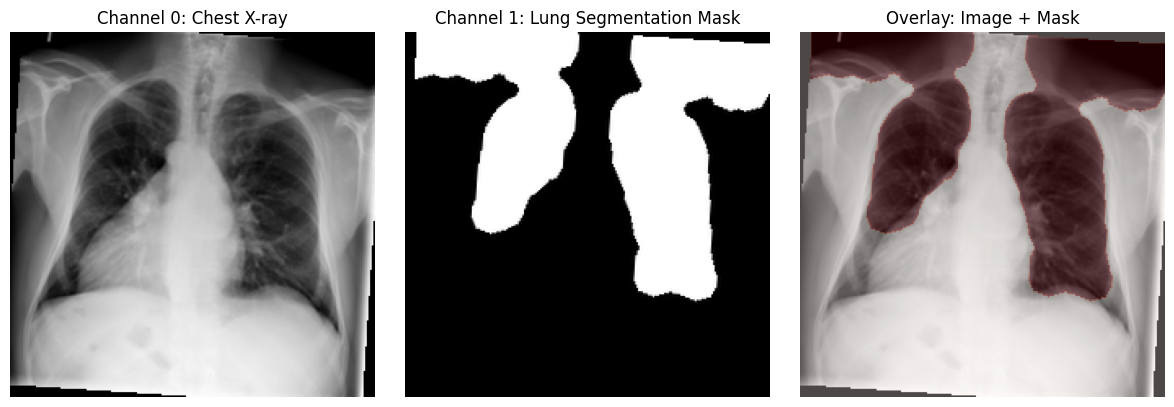

Active diseases: ['Cardiomegaly']


In [16]:
# Visualize a sample to verify the 2-channel input
import matplotlib.pyplot as plt

# Get a sample
sample_img, sample_labels = train_ds[0]
print(f'Sample shape: {sample_img.shape}')  # Should be [2, 224, 224]
print(f'Channel 0 (image) range: [{sample_img[0].min():.3f}, {sample_img[0].max():.3f}]')
print(f'Channel 1 (mask) range: [{sample_img[1].min():.3f}, {sample_img[1].max():.3f}]')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Channel 0: Image
axes[0].imshow(sample_img[0].numpy(), cmap='gray')
axes[0].set_title('Channel 0: Chest X-ray')
axes[0].axis('off')

# Channel 1: Segmentation mask
axes[1].imshow(sample_img[1].numpy(), cmap='gray')
axes[1].set_title('Channel 1: Lung Segmentation Mask')
axes[1].axis('off')

# Overlay
overlay = sample_img[0].numpy().copy()
mask = sample_img[1].numpy()
axes[2].imshow(overlay, cmap='gray')
axes[2].imshow(mask, cmap='Reds', alpha=0.3)
axes[2].set_title('Overlay: Image + Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Show active diseases
active_diseases = [DISEASE_CATEGORIES[i] for i, v in enumerate(sample_labels) if v == 1]
print(f'Active diseases: {active_diseases if active_diseases else "None (Normal)"}')

In [17]:
# =============================================================================
# Modified MobileNetV2 for 2-Channel Input
# =============================================================================

def get_mobilenet_v2_multichannel(num_classes, in_channels=2, pretrained=True):
    """
    Create MobileNetV2 modified for multi-channel input.
    
    Strategy: Replace the first conv layer to accept 2 channels instead of 3.
    We initialize the new conv layer by averaging the pretrained RGB weights.
    """
    # Load pretrained MobileNetV2
    model = models.mobilenet_v2(pretrained=pretrained)
    
    # Get the original first conv layer
    original_conv = model.features[0][0]  # Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
    
    # Create new first conv layer with desired input channels
    new_conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias is not None
    )
    
    # Initialize new conv weights from pretrained weights
    with torch.no_grad():
        if pretrained:
            # Original weights shape: [32, 3, 3, 3] (out_channels, in_channels, H, W)
            original_weights = original_conv.weight.data
            
            # For 2 channels:
            # Channel 0 (image): average of RGB weights (grayscale-like)
            # Channel 1 (mask): average of RGB weights (treat as additional spatial info)
            avg_weight = original_weights.mean(dim=1, keepdim=True)  # [32, 1, 3, 3]
            
            # Concatenate for 2 input channels
            new_weights = torch.cat([avg_weight, avg_weight], dim=1)  # [32, 2, 3, 3]
            new_conv.weight.data = new_weights
            
            if original_conv.bias is not None:
                new_conv.bias.data = original_conv.bias.data.clone()
        else:
            # Random initialization
            nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')
    
    # Replace the first conv layer
    model.features[0][0] = new_conv
    
    # Replace classifier for multi-label output
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )
    
    return model

# Create model
model = get_mobilenet_v2_multichannel(
    num_classes=len(DISEASE_CATEGORIES),
    in_channels=cfg.in_channels,
    pretrained=True
).to(cfg.device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

# Verify model accepts 2-channel input
print(f'Model created successfully!')
print(f'First conv layer: {model.features[0][0]}')
print(f'Expected input: [batch_size, {cfg.in_channels}, {cfg.img_size}, {cfg.img_size}]')

# Test forward pass
dummy_input = torch.randn(2, cfg.in_channels, cfg.img_size, cfg.img_size).to(cfg.device)
dummy_output = model(dummy_input)
print(f'\nTest forward pass:')
print(f'  Input shape: {dummy_input.shape}')
print(f'  Output shape: {dummy_output.shape}')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created successfully!
First conv layer: Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Expected input: [batch_size, 2, 224, 224]

Test forward pass:
  Input shape: torch.Size([2, 2, 224, 224])
  Output shape: torch.Size([2, 14])


In [18]:
# =============================================================================
# Training & Validation Functions
# =============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, targets in loader:
        imgs = imgs.to(device)  # Shape: [batch, 2, 224, 224]
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    all_targets = []
    all_preds = []
    
    for imgs, targets in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(probs)
        all_targets.append(targets.numpy())
    
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # Calculate per-class AUC
    aucs = []
    for i in range(all_targets.shape[1]):
        try:
            aucs.append(roc_auc_score(all_targets[:, i], all_preds[:, i]))
        except Exception:
            aucs.append(np.nan)
    
    return np.nanmean(aucs), aucs

print('Training functions defined')

Training functions defined


In [19]:
# =============================================================================
# Training Loop
# =============================================================================

from tqdm import tqdm

best_auc = 0.0
history = {'train_loss': [], 'val_auc': []}

print(f'\n{"="*60}')
print(f'Starting Training: Option 6 - Segmentation Channel Input')
print(f'{"="*60}')
print(f'Input: 2 channels (image + lung segmentation mask)')
print(f'Epochs: {cfg.epochs}, Batch size: {cfg.batch_size}, LR: {cfg.lr}')
print(f'{"="*60}\n')

for epoch in range(cfg.epochs):
    print(f'Epoch {epoch+1}/{cfg.epochs}')
    
    # Training
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc='Training')
    for imgs, targets in pbar:
        imgs = imgs.to(cfg.device)
        targets = targets.to(cfg.device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    val_auc, per_class_auc = validate(model, val_loader, cfg.device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_auc'].append(val_auc)
    
    print(f'  Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}')
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'option6_segmentation_channel_best.pth')
        print(f'  ✓ New best model saved! (AUC: {best_auc:.4f})')
    print()

print(f'{"="*60}')
print(f'Training Complete!')
print(f'Best Validation AUC: {best_auc:.4f}')
print(f'{"="*60}')


Starting Training: Option 6 - Segmentation Channel Input
Input: 2 channels (image + lung segmentation mask)
Epochs: 8, Batch size: 32, LR: 0.0001

Epoch 1/8


Training: 100%|██████████| 3246/3246 [06:42<00:00,  8.06it/s, loss=0.1975]


  Train Loss: 0.1639 | Val AUC: 0.7909
  ✓ New best model saved! (AUC: 0.7909)

Epoch 2/8


Training: 100%|██████████| 3246/3246 [06:41<00:00,  8.09it/s, loss=0.2178]


  Train Loss: 0.1526 | Val AUC: 0.8078
  ✓ New best model saved! (AUC: 0.8078)

Epoch 3/8


Training: 100%|██████████| 3246/3246 [06:36<00:00,  8.19it/s, loss=0.0957]


  Train Loss: 0.1491 | Val AUC: 0.8165
  ✓ New best model saved! (AUC: 0.8165)

Epoch 4/8


Training: 100%|██████████| 3246/3246 [06:25<00:00,  8.41it/s, loss=0.1331]


  Train Loss: 0.1466 | Val AUC: 0.8205
  ✓ New best model saved! (AUC: 0.8205)

Epoch 5/8


Training: 100%|██████████| 3246/3246 [06:21<00:00,  8.50it/s, loss=0.1547]


  Train Loss: 0.1443 | Val AUC: 0.8240
  ✓ New best model saved! (AUC: 0.8240)

Epoch 6/8


Training: 100%|██████████| 3246/3246 [06:04<00:00,  8.90it/s, loss=0.0614]


  Train Loss: 0.1423 | Val AUC: 0.8304
  ✓ New best model saved! (AUC: 0.8304)

Epoch 7/8


Training: 100%|██████████| 3246/3246 [06:03<00:00,  8.92it/s, loss=0.1052]


  Train Loss: 0.1404 | Val AUC: 0.8219

Epoch 8/8


Training: 100%|██████████| 3246/3246 [06:03<00:00,  8.93it/s, loss=0.1793]


  Train Loss: 0.1383 | Val AUC: 0.8222

Training Complete!
Best Validation AUC: 0.8304


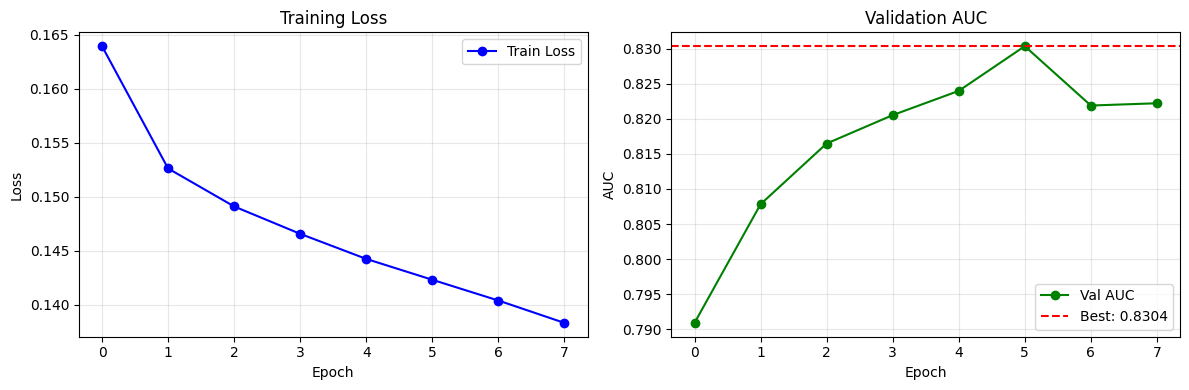

In [20]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], 'b-o', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history['val_auc'], 'g-o', label='Val AUC')
axes[1].axhline(y=best_auc, color='r', linestyle='--', label=f'Best: {best_auc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('option6_training_history.png', dpi=150)
plt.show()

In [21]:
# =============================================================================
# Final Evaluation on Test Set
# =============================================================================

# Load best model
model.load_state_dict(torch.load('option6_segmentation_channel_best.pth'))
# Evaluate on test set
test_auc, test_per_class_auc = validate(model, test_loader, cfg.device)

print(f'\n{"="*60}')
print(f'Test Set Evaluation - Option 6: Segmentation Channel Input')
print(f'{"="*60}')
print(f'\nOverall Test AUC: {test_auc:.4f}')
print(f'\nPer-class AUC:')
print('-' * 40)

for disease, auc in zip(DISEASE_CATEGORIES, test_per_class_auc):
    print(f'  {disease:20s}: {auc:.4f}')

print(f'\n{"="*60}')

/tmp/ipykernel_4713/1029073325.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('option6_segmentation_channel_best.pth'))



Test Set Evaluation - Option 6: Segmentation Channel Input

Overall Test AUC: 0.8278

Per-class AUC:
----------------------------------------
  Atelectasis         : 0.7939
  Cardiomegaly        : 0.9286
  Effusion            : 0.8933
  Infiltration        : 0.6928
  Mass                : 0.8623
  Nodule              : 0.7088
  Pneumonia           : 0.7329
  Pneumothorax        : 0.8456
  Consolidation       : 0.7819
  Edema               : 0.8747
  Emphysema           : 0.9331
  Fibrosis            : 0.7963
  Pleural_Thickening  : 0.7612
  Hernia              : 0.9831



In [22]:
# =============================================================================
# Summary
# =============================================================================

print("""
================================================================================
Option 6: Segmentation Channel Input - Summary
================================================================================

Key Features:
-------------
• Rule-based lung segmentation mask passed as additional input channel
• Network input: 2 channels [image, segmentation_mask]
• Modified MobileNetV2 with 2-channel first conv layer
• Pretrained weights adapted by averaging RGB channel weights

Advantages:
-----------
• Network learns to leverage spatial lung region information
• Segmentation provides anatomical prior knowledge
• End-to-end learning - network decides how to use segmentation info
• No information loss (unlike masking approaches)

Network Architecture:
--------------------
• Input: [batch, 2, 224, 224]
  - Channel 0: Grayscale chest X-ray
  - Channel 1: Binary lung segmentation mask
• Backbone: MobileNetV2 (modified first layer)
• Output: 14-class multi-label predictions

================================================================================
""")

print(f'Final Results:')
print(f'  Best Validation AUC: {best_auc:.4f}')
print(f'  Test AUC: {test_auc:.4f}')


Option 6: Segmentation Channel Input - Summary

Key Features:
-------------
• Rule-based lung segmentation mask passed as additional input channel
• Network input: 2 channels [image, segmentation_mask]
• Modified MobileNetV2 with 2-channel first conv layer
• Pretrained weights adapted by averaging RGB channel weights

Advantages:
-----------
• Network learns to leverage spatial lung region information
• Segmentation provides anatomical prior knowledge
• End-to-end learning - network decides how to use segmentation info
• No information loss (unlike masking approaches)

Network Architecture:
--------------------
• Input: [batch, 2, 224, 224]
  - Channel 0: Grayscale chest X-ray
  - Channel 1: Binary lung segmentation mask
• Backbone: MobileNetV2 (modified first layer)
• Output: 14-class multi-label predictions


Final Results:
  Best Validation AUC: 0.8304
  Test AUC: 0.8278
